# Training Detectron2 for blood cells detection
category_dict = {"cells":0, "Platelets":1, "RBC":2, "WBC":3}


# Installation
* detectron2 is not pre-installed in this kaggle docker, so let's install it.
* we need to know CUDA and pytorch version to install correct detectron2.

In [1]:
!nvidia-smi

Mon May  3 15:13:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.7.0 True


* It seems CUDA=11.0 and torch==1.7.0 is used in this kaggle docker image.
* See installation for details.
https://detectron2.readthedocs.io/en/latest/tutorials/install.html

# Install Pre-Built Detectron2

In [3]:
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu110/torch1.7/index.html
     |████████████████████████████████| 6.3 MB 1.6 MB/s 
     |████████████████████████████████| 47 kB 1.6 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-py3-none-any.whl size=58542 sha256=1520714058c846bfd3a2035700e6f0eed7eab185faf0723a299284c7a7a849cd
  Stored in directory: /root/.cache/pip/wheels/a6/02/09/10e3a0150eb92e5ecbee3677a813bffc32a8ec6f876bfe4adf
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272445 sha256=d3673339c659480cc57b26c6560f0444738a97288f3c34987be49c2058a7df1a
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
Successfully built fvcore pycocotools


In [4]:
!python -m detectron2.utils.collect_env

----------------------  -------------------------------------------------------------------------------
sys.platform            linux
Python                  3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) [GCC 9.3.0]
numpy                   1.19.5
detectron2              0.4 @/opt/conda/lib/python3.7/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.0
detectron2 arch flags   3.7, 5.0, 5.2, 6.0, 6.1, 7.0, 7.5, 8.0
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.7.0 @/opt/conda/lib/python3.7/site-packages/torch
PyTorch debug build     True
GPU available           True
GPU 0                   Tesla P100-PCIE-16GB (arch=6.0)
CUDA_HOME               /usr/local/cuda
Pillow                  7.2.0
torchvision             0.8.1 @/opt/conda/lib/python3.7/site-packages/torchvision
torchvision arch flags  3.5, 5.0, 6.0, 7.0, 7.5, 8.0
fvcore                  0.1.3.post20210317
cv2                     4.5.1
---------------------

# Import Libraries

In [5]:
# import some common libraries
import numpy as np
import os, json, cv2, random
import skimage.io as io
import pylab
import sys
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image


# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
#plt.rcParams["figure.figsize"] = [16,9]

# Register Dataset

Detectron2 keeps track of a list of available datasets in a registry, so we must register our custom data with Detectron2 so it can be invoked for training.

If you want to use a custom dataset while also reusing detectron2’s data loaders, you will need to
*  Register your dataset (i.e., tell detectron2 how to obtain your dataset).
* Optionally, register metadata for your dataset.

In [6]:
dataset_dir = "../input/bccd-coco"
train_dir = "train/"
val_dir = "valid/"
test_dir = "test/"

In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("bccd_train", {}, os.path.join(dataset_dir,train_dir,"_annotations.coco.json"), os.path.join(dataset_dir,train_dir))
register_coco_instances("bccd_val", {}, os.path.join(dataset_dir,val_dir,"_annotations.coco.json"), os.path.join(dataset_dir,val_dir))
register_coco_instances("bccd_test", {}, os.path.join(dataset_dir,test_dir,"_annotations.coco.json"), os.path.join(dataset_dir,test_dir))

In [8]:
dataset_dicts = DatasetCatalog.get("bccd_train")
metadata_dicts = MetadataCatalog.get("bccd_train")

WARNING [05/03 15:13:49 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 15:13:49 d2.data.datasets.coco]: Loaded 255 images in COCO format from ../input/bccd-coco/train/_annotations.coco.json


# Data visualisation

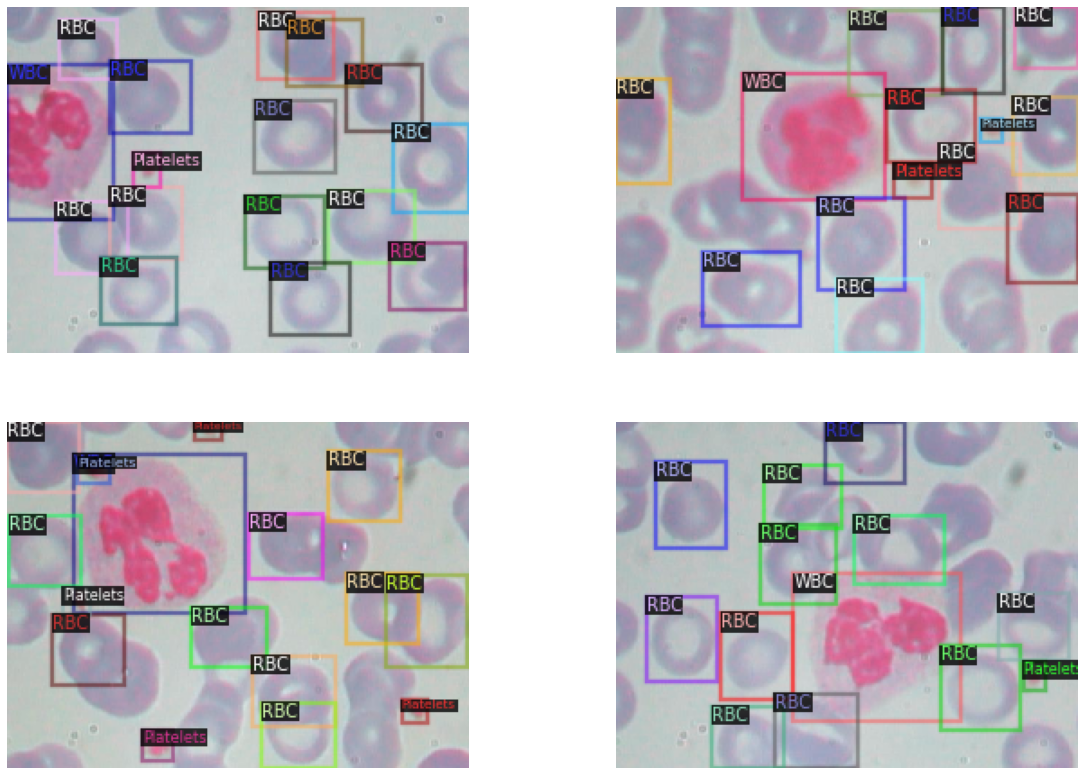

In [9]:
fig, ax = plt.subplots(2, 2, figsize =(20,14))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(dataset_dicts, 4):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts, 
                   scale=0.4, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].imshow(out.get_image()[:, :, ::-1])
    

# Data Augmentation
The dataset is transformed by changing the brighness and flipping the image with 50% probability.

In [10]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.Resize((640,640)),
                      T.RandomBrightness(0.9, 1.1),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      T.RandomCrop("absolute", (640, 640))
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

# Training


In [11]:

cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 
#config_name = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = ("bccd_train",)
cfg.DATASETS.TEST = ("bccd_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 3500 #adjust up if val mAP is still rising, adjust down if overfit
#cfg.SOLVER.STEPS = (100, 500) # must be less than  MAX_ITER 
#cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
#trainer = AugTrainer(cfg) 
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


[05/03 15:13:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:03, 50.5MB/s]                           


[05/03 15:14:03 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[05/03 15:14:19 d2.utils.events]:  eta: 0:39:36  iter: 19  total_loss: 3.125  loss_cls: 1.888  loss_box_reg: 0.8521  loss_rpn_cls: 0.3131  loss_rpn_loc: 0.07497  time: 0.6983  data_time: 0.0220  lr: 4.9953e-06  max_mem: 3795M
[05/03 15:14:33 d2.utils.events]:  eta: 0:41:07  iter: 39  total_loss: 2.906  loss_cls: 1.769  loss_box_reg: 0.8635  loss_rpn_cls: 0.1581  loss_rpn_loc: 0.07968  time: 0.7075  data_time: 0.0126  lr: 9.9903e-06  max_mem: 3795M
[05/03 15:14:47 d2.utils.events]:  eta: 0:39:29  iter: 59  total_loss: 2.609  loss_cls: 1.526  loss_box_reg: 0.8728  loss_rpn_cls: 0.1661  loss_rpn_loc: 0.07479  time: 0.7049  data_time: 0.0134  lr: 1.4985e-05  max_mem: 3795M
[05/03 15:15:01 d2.utils.events]:  eta: 0:39:43  iter: 79  total_loss: 2.242  loss_cls: 1.26  loss_box_reg: 0.8522  loss_rpn_cls: 0.1019  loss_rpn_loc: 0.07608  time: 0.7066  data_time: 0.0250  lr: 1.998e-05  max_mem: 3795M
[05/03 15:15:16 d2.utils.events]:  eta: 0:41:19  iter: 99  total_loss: 1.985  loss_cls: 1  loss_bo

# evaluator

In [12]:
evaluator = COCOEvaluator("bccd_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "bccd_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [05/03 15:56:26 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [05/03 15:56:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 15:56:26 d2.data.datasets.coco]: Loaded 73 images in COCO format from ../input/bccd-coco/valid/_annotations.coco.json
[05/03 15:56:26 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/03 15:56:26 d2.data.common]: Serializing 73 elements to byte tensors and concatenating them all ...
[05/03 15:56:26 d2.data.common]: Serialized dataset takes 0.05 MiB
[05/03 15:56:26 d2.evaluation.evaluator]: Start inference on 73 images
[05/03 15:56:27 d2.evaluation.evaluator]: Inference done 11/73. 0.0749 s / img. ETA=0:00:04
[05/03 15:56:32 d2.evaluation.evaluator]: Total infere

OrderedDict([('bbox',
              {'AP': 61.46045582961648,
               'AP50': 90.12763029143869,
               'AP75': 72.06417792341702,
               'APs': 48.54785478547854,
               'APm': 60.658395511174255,
               'APl': 46.716026078304026,
               'AP-cells': nan,
               'AP-Platelets': 46.44492964202704,
               'AP-RBC': 60.45210300540007,
               'AP-WBC': 77.48433484142235})])

In [13]:
import pandas as pd
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.T

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
data_time,0.011371,0.011764,0.012047,0.026189,0.029681,0.029793,0.030214,0.031253,0.031269,0.029501,...,0.028493,0.030881,0.029997,0.028438,0.031710,0.031905,0.030802,0.031877,0.031021,0.031623
eta_seconds,2376.817171,2467.918966,2369.517518,2383.655931,2479.228908,2507.457348,2495.069428,2480.217825,2468.735163,2453.863264,...,134.311696,119.370753,104.478685,89.591079,74.638935,59.667339,44.712407,29.788838,14.901657,0.000000
fast_rcnn/cls_accuracy,0.058594,0.169922,0.678711,0.750000,0.750000,0.750000,0.750000,0.752930,0.768555,0.815430,...,0.926758,0.927734,0.923828,0.917969,0.926758,0.924805,0.923828,0.931641,0.932617,0.920898
fast_rcnn/false_negative,0.015625,0.160156,0.742188,0.996094,1.000000,1.000000,1.000000,0.996094,0.921875,0.748950,...,0.140625,0.156250,0.160156,0.156250,0.136719,0.187500,0.183594,0.152344,0.140625,0.167969
fast_rcnn/fg_cls_accuracy,0.148438,0.117188,0.058594,0.000000,0.000000,0.000000,0.000000,0.000000,0.070312,0.245743,...,0.859375,0.843750,0.839844,0.843750,0.863281,0.812500,0.816406,0.847656,0.859375,0.832031
iteration,19.000000,39.000000,59.000000,79.000000,99.000000,119.000000,139.000000,159.000000,179.000000,199.000000,...,3319.000000,3339.000000,3359.000000,3379.000000,3399.000000,3419.000000,3439.000000,3459.000000,3479.000000,3499.000000
loss_box_reg,0.852083,0.863462,0.872764,0.852226,0.867948,0.835235,0.824209,0.816553,0.810352,0.796541,...,0.280142,0.280117,0.266289,0.283530,0.270688,0.261832,0.277467,0.260085,0.256300,0.285188
loss_cls,1.887742,1.769256,1.526207,1.259578,1.000230,0.812084,0.706431,0.637750,0.586632,0.535925,...,0.169300,0.162719,0.167164,0.184716,0.176993,0.174973,0.184823,0.174312,0.155465,0.188519
loss_rpn_cls,0.313087,0.158072,0.166109,0.101928,0.052943,0.046449,0.044196,0.045313,0.037585,0.034541,...,0.003983,0.005905,0.006778,0.006725,0.007471,0.005047,0.006286,0.004521,0.003744,0.005859
loss_rpn_loc,0.074971,0.079675,0.074794,0.076084,0.073263,0.067936,0.075646,0.067607,0.066700,0.058162,...,0.036900,0.036383,0.036372,0.037536,0.037664,0.035394,0.038921,0.034585,0.035911,0.040536


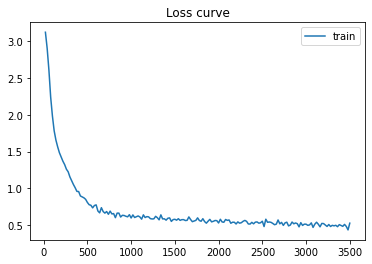

In [14]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()


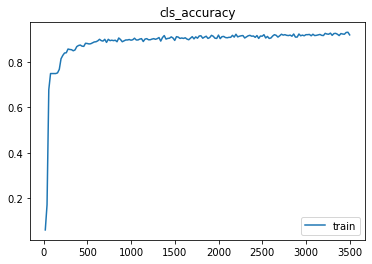

In [15]:
# 1. Loss curve
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("cls_accuracy")
plt.show()


# predictor
A predictor is defined with 0.5 threshold score which gives bounding box and label for the test images

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("bccd_test", )
predictor = DefaultPredictor(cfg)

In [17]:
test_dataset_dicts = DatasetCatalog.get("bccd_test")
test_metadata_dicts = MetadataCatalog.get("bccd_test")

WARNING [05/03 15:56:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/03 15:56:35 d2.data.datasets.coco]: Loaded 36 images in COCO format from ../input/bccd-coco/test/_annotations.coco.json


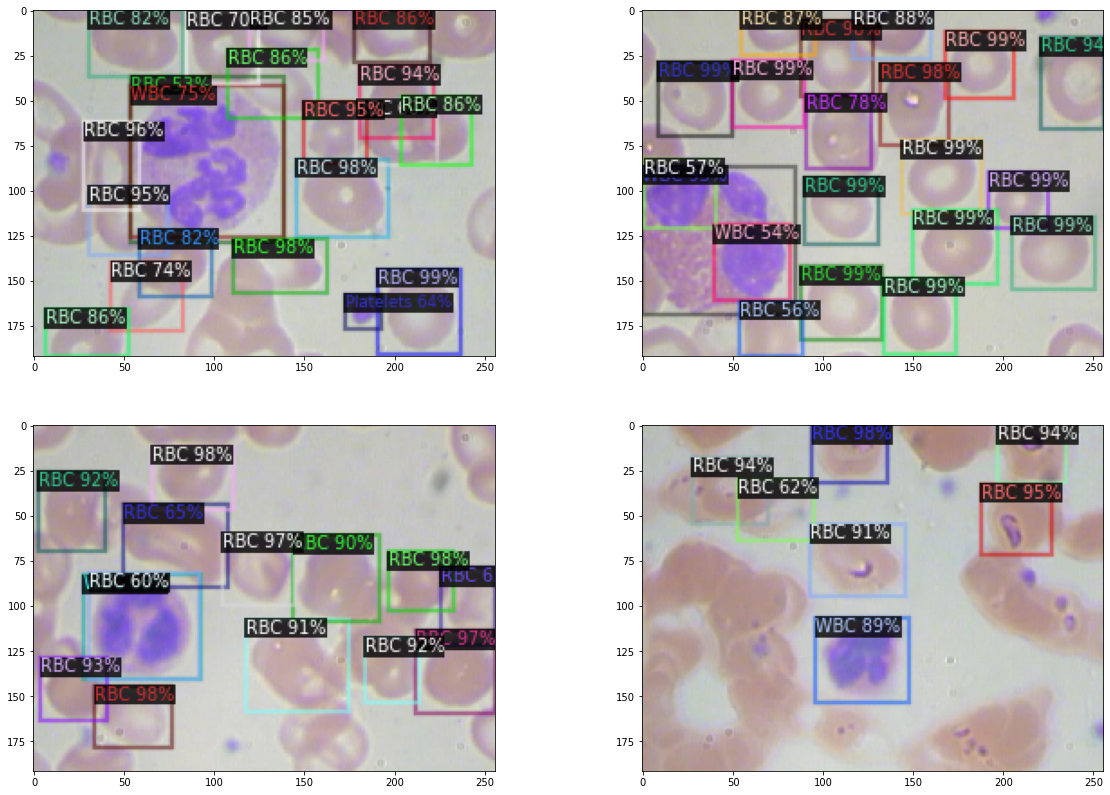

In [18]:
fig, ax = plt.subplots(2, 2, figsize =(20,14))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(test_dataset_dicts, 4):
    i=i+1    
    im = io.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata_dicts, 
                   scale=0.4, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])